In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [81]:
!pip install prophet

In [82]:
df18 = pd.read_csv('https://github.com/vitarium/projectf/raw/main/data18.csv', sep = '\t')
df19 = pd.read_csv('https://github.com/vitarium/projectf/raw/main/data19.csv', sep = '\t')
df20 = pd.read_csv('https://github.com/vitarium/projectf/raw/main/data20.csv', sep = '\t')
df21 = pd.read_csv('https://github.com/vitarium/projectf/raw/main/data21.csv', sep = '\t')
df22 = pd.read_csv('https://github.com/vitarium/projectf/raw/main/data22.csv', sep = '\t')
frames = [df18, df19, df20, df21, df22]
df = pd.concat(frames)

In [83]:
df.shape

(212911, 11)

In [84]:
df.dtypes

Unnamed: 0         int64
DECLARANT          int64
DECLARANT_ISO     object
PARTNER            int64
PARTNER_ISO       object
PRODUCT_HS        object
FLOW               int64
TRANSPORT_MODE     int64
PERIOD             int64
VALUE_IN_EUROS     int64
QUANTITY_IN_KG     int64
dtype: object

In [85]:
df.head(5)

,Unnamed: 0,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_HS,FLOW,TRANSPORT_MODE,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG
0,51444,1,FR,73,BY,010513,2,3,201852,234286,17600
1,51445,1,FR,73,BY,020714,2,3,201852,71648,318750
2,51446,1,FR,73,BY,020910,2,3,201852,51600,60903
3,51447,1,FR,73,BY,030313,2,3,201852,107639,85024
4,51448,1,FR,73,BY,030399,1,3,201852,11968,20436


Легенда
DECLARANT_ISO - код одной из стран ЕС
PARTNER_ISO - код Беларуси
PRODUCT_HS - код ТНВЭД перемещаемого груза
FLOW - 1-импорт в ЕС, 2-экспорт из ЕС
TRANSPORT_MODE - код транспорта, которым перемещался груз
PERIOD - 2018-2022
VALUE_IN_EUROS - стоимость перевезенных грузов
QUANTITY_IN_KG - вес перевезенных грузов
Источник: Евростат

In [86]:
df.columns = df.columns.str.replace('Unnamed: 0','id')
df.head(1)

,id,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_HS,FLOW,TRANSPORT_MODE,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG
0,51444,1,FR,73,BY,010513,2,3,201852,234286,17600


In [87]:
df = df.drop(columns=['DECLARANT', 'PARTNER'])
df.head(1)

,id,DECLARANT_ISO,PARTNER_ISO,PRODUCT_HS,FLOW,TRANSPORT_MODE,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG
0,51444,FR,BY,010513,2,3,201852,234286,17600


In [139]:
df['cost_per_weight'] = df['VALUE_IN_EUROS']/df['QUANTITY_IN_KG']*100

In [147]:
df['PERIOD'].value_counts()

201952    45278
202152    44989
201852    44374
202052    43155
202252    35115
Name: PERIOD, dtype: int64

In [137]:
df['Tradelane'] = np.where(df['FLOW']==1, df['PARTNER_ISO'] + "-" + df['DECLARANT_ISO'], df['DECLARANT_ISO'] + "-" + df['PARTNER_ISO'])
df.head(1)

,id,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,Tradelane,Transport_mode_desc,HS4,cost_per_weight
0,51444,FR,BY,2,201852,234286,17600,FR-BY,Road,01,1331.170455


In [89]:
def rename(df):
  if df['TRANSPORT_MODE'] == 0:
    return 'Unknown'
  elif df['TRANSPORT_MODE'] == 1:
    return 'Sea'
  elif df['TRANSPORT_MODE'] == 2:
    return 'Rail'
  elif df['TRANSPORT_MODE'] == 3:
    return 'Road'
  elif df['TRANSPORT_MODE'] == 4:
    return 'Air'
  elif df['TRANSPORT_MODE'] == 5:
    return 'Post'
  elif df['TRANSPORT_MODE'] == 7:
    return 'Fixed Mechanism'
  elif df['TRANSPORT_MODE'] == 8:
    return 'Inland Waterway'
  else:
    return 'Self Propulsion'

df['Transport_mode_desc'] = df.apply(rename, axis=1)
df.head(1)

,id,DECLARANT_ISO,PARTNER_ISO,PRODUCT_HS,FLOW,TRANSPORT_MODE,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,Tradelane,Transport_mode_desc
0,51444,FR,BY,010513,2,3,201852,234286,17600,FR-BY,Road


In [90]:
df['HS4'] = df['PRODUCT_HS'].str[:2]
df.head(1)

,id,DECLARANT_ISO,PARTNER_ISO,PRODUCT_HS,FLOW,TRANSPORT_MODE,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,Tradelane,Transport_mode_desc,HS4
0,51444,FR,BY,010513,2,3,201852,234286,17600,FR-BY,Road,01


In [91]:
df = df.drop(columns=['TRANSPORT_MODE', 'PRODUCT_HS'])
df.head(1)

,id,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,Tradelane,Transport_mode_desc,HS4
0,51444,FR,BY,2,201852,234286,17600,FR-BY,Road,01


In [92]:
hs = pd.read_excel('https://github.com/vitarium/projectf/raw/main/HS_2017.xlsx')
hs.head(1)

,hs4,Sorting Key,HS CODE,LEVEL,DASHES,EN_without_dashes,EN,BG,CS,DA,...,LT,LV,MT,NL,PL,PT,RO,SK,SL,SV
0,0,0,NaN,1,NaN,This classification has been uploaded in RAMON...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
hs['HS CODE']=hs['HS CODE'].str.replace('.','', 3, regex=False)
hs.head(1)

,hs4,Sorting Key,HS CODE,LEVEL,DASHES,EN_without_dashes,EN,BG,CS,DA,...,LT,LV,MT,NL,PL,PT,RO,SK,SL,SV
0,0,0,NaN,1,NaN,This classification has been uploaded in RAMON...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
hs['len']=hs['HS CODE'].str.len()
hs.head(1)

,hs4,Sorting Key,HS CODE,LEVEL,DASHES,EN_without_dashes,EN,BG,CS,DA,...,LV,MT,NL,PL,PT,RO,SK,SL,SV,len
0,0,0,NaN,1,NaN,This classification has been uploaded in RAMON...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
hs4=hs.query('len== 2')
hs4.head(1)

,hs4,Sorting Key,HS CODE,LEVEL,DASHES,EN_without_dashes,EN,BG,CS,DA,...,LV,MT,NL,PL,PT,RO,SK,SL,SV,len
2,100,10021000090,01,2,NaN,CHAPTER 1 - LIVE ANIMALS,CHAPTER 1 - LIVE ANIMALS,ГЛАВА 1 - ЖИВИ ЖИВОТНИ,KAPITOLA 1 - ŽIVÁ ZVÍŘATA,KAPITEL 1 - LEVENDE DYR,...,1. NODAĻA - DZĪVI DZĪVNIEKI,KAPITLU 1 - ANNIMALI ĦAJJIN,HOOFDSTUK 1 - LEVENDE DIEREN,DZIAŁ 1 - ZWIERZĘTA ŻYWE,CAPÍTULO 1 - ANIMAIS VIVOS,CAPITOLUL 1 - ANIMALE VII,1. KAPITOLA - ŽIVÉ ZVIERATÁ,POGLAVJE 1 - ŽIVE ŽIVALI,KAPITEL 1 - LEVANDE DJUR,2.0


In [202]:
hs4['EN']=hs4['EN'].map(lambda x: x.lstrip('CHAPTER '))

C:\Users\LIV\AppData\Local\Temp\ipykernel_2496\2621542525.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [203]:
hs4.head(5)

,hs4,Sorting Key,HS CODE,LEVEL,DASHES,EN_without_dashes,EN,BG,CS,DA,...,LV,MT,NL,PL,PT,RO,SK,SL,SV,len
2,100,10021000090,01,2,NaN,CHAPTER 1 - LIVE ANIMALS,1 - LIVE ANIMALS,ГЛАВА 1 - ЖИВИ ЖИВОТНИ,KAPITOLA 1 - ŽIVÁ ZVÍŘATA,KAPITEL 1 - LEVENDE DYR,...,1. NODAĻA - DZĪVI DZĪVNIEKI,KAPITLU 1 - ANNIMALI ĦAJJIN,HOOFDSTUK 1 - LEVENDE DIEREN,DZIAŁ 1 - ZWIERZĘTA ŻYWE,CAPÍTULO 1 - ANIMAIS VIVOS,CAPITOLUL 1 - ANIMALE VII,1. KAPITOLA - ŽIVÉ ZVIERATÁ,POGLAVJE 1 - ŽIVE ŽIVALI,KAPITEL 1 - LEVANDE DJUR,2.0
52,200,20021000090,02,2,NaN,CHAPTER 2 - MEAT AND EDIBLE MEAT OFFAL,2 - MEAT AND EDIBLE MEAT OFFAL,"ГЛАВА 2 - МЕСА И КАРАНТИИ, ГОДНИ ЗА КОНСУМАЦИЯ",KAPITOLA 2 - MASO A JEDLÉ DROBY,KAPITEL 2 - KØD OG SPISELIGE SLAGTEBIPRODUKTER,...,2. NODAĻA - GAĻA UN ĒDAMI GAĻAS SUBPRODUKTI,KAPITLU 2 - LAĦAM U ĠEWWIENI LI JITTIEKEL,HOODSTUK 2 - VLEES EN EETBARE SLACHTAFVALLEN,DZIAŁ 2 - MIĘSO I PODROBY JADALNE,"CAPÍTULO 2 - CARNES E MIUDEZAS, COMESTÍVEIS",CAPITOLUL 2 - CARNE ȘI ORGANE COMESTIBILE,2. KAPITOLA - MÄSO A JEDLÉ MÄSOVÉ DROBY,POGLAVJE 2 - MESO IN UŽITNI KLAVNIČNI PROIZVODI,KAPITEL 2 - KÖTT OCH ÄTBARA SLAKTBIPRODUKTER,2.0
140,300,30021000090,03,2,NaN,"CHAPTER 3 - FISH AND CRUSTACEANS, MOLLUSCS AND...","3 - FISH AND CRUSTACEANS, MOLLUSCS AND OTHER ...","ГЛАВА 3 - РИБИ И РАКООБРАЗНИ, МЕКОТЕЛИ И ДРУГИ...","KAPITOLA 3 - RYBY A KORÝŠI, MĚKKÝŠI A JINÍ VOD...","KAPITEL 3 - FISK OG KREBSDYR, BLØDDYR OG ANDRE...",...,"3. NODAĻA - ZIVIS UN VĒŽVEIDĪGIE, MĪKSTMIEŠI U...","KAPITLU 3 - ĦUT U KRUSTAĊJI, MOLLUSKI U INVERT...","HOOFDSTUK 3 - VIS, SCHAALDIEREN, WEEKDIEREN EN...","DZIAŁ 3 - RYBY I SKORUPIAKI, MIĘCZAKI I POZOST...","CAPÍTULO 3 - PEIXES E CRUSTÁCEOS, MOLUSCOS E O...","CAPITOLUL 3 - PEȘTI ȘI CRUSTACEE, MOLUȘTE ȘI A...","3. KAPITOLA - RYBY A KÔROVCE, MÄKKÝŠE A OSTATN...","POGLAVJE 3 - RIBE IN RAKI, MEHKUŽCI IN DRUGI V...","KAPITEL 3 - FISK SAMT KRÄFTDJUR, BLÖTDJUR OCH ...",2.0
416,400,40021000090,04,2,NaN,CHAPTER 4 - DAIRY PRODUCE; BIRDS' EGGS; NATURA...,4 - DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY...,ГЛАВА 4 - МЛЯКО И МЛЕЧНИ ПРОДУКТИ; ПТИЧИ ЯЙЦА;...,KAPITOLA 4 - MLÉKO A MLÉČNÉ VÝROBKY; PTAČÍ VEJ...,KAPITEL 4 - MÆLK OG MEJERIPRODUKTER; FUGLEÆG; ...,...,4. NODAĻA - PIENA PĀRSTRĀDES PRODUKTI; PUTNU O...,KAPITLU 4 - PRODOTTI TAL-ĦALIB; BAJD TAT-TJUR;...,HOOFDSTUK 4 - MELK EN ZUIVELPRODUCTEN; VOGELEI...,DZIAŁ 4 - PRODUKCJA MLECZARSKA; JAJA PTASIE; M...,CAPÍTULO 4 - LEITE E LACTICÍNIOS; OVOS DE AVES...,CAPITOLUL 4 - LAPTE ȘI PRODUSE LACTATE; OUĂ DE...,4. KAPITOLA - MLIEKO A MLIEČNE VÝROBKY; VTÁČIE...,POGLAVJE 4 - MLEČNI PROIZVODI; PTIČJA JAJCA; N...,KAPITEL 4 - MEJERIPRODUKTER; FÅGELÄGG; NATURLI...,2.0
463,500,50021000090,05,2,NaN,"CHAPTER 5 - PRODUCTS OF ANIMAL ORIGIN, NOT ELS...","5 - PRODUCTS OF ANIMAL ORIGIN, NOT ELSEWHERE ...",ГЛАВА 5 - ДРУГИ ПРОДУКТИ ОТ ЖИВОТИНСКИ ПРОИЗХО...,"KAPITOLA 5 - VÝROBKY ŽIVOČIŠNÉHO PŮVODU, JINDE...",KAPITEL 5 - DIVERSE PRODUKTER AF ANIMALSK OPRI...,...,"5. NODAĻA - DZĪVNIEKU IZCELSMES PRODUKTI, KAS ...",KAPITLU 5 - PRODOTTI ĠEJJIN MILL-ANNIMALI LI M...,HOOFDSTUK 5 - ANDERE PRODUCTEN VAN DIERLIJKE O...,"DZIAŁ 5 - PRODUKTY POCHODZENIA ZWIERZĘCEGO, GD...","CAPÍTULO 5 - OUTROS PRODUTOS DE ORIGEM ANIMAL,...","CAPITOLUL 5 - ALTE PRODUSE DE ORIGINE ANIMALĂ,...","5. KAPITOLA - PRODUKTY ŽIVOČÍŠNEHO PÔVODU, IND...","POGLAVJE 5 - PROIZVODI ŽIVALSKEGA IZVORA, KI N...","KAPITEL 5 - PRODUKTER AV ANIMALISKT URSPRUNG, ...",2.0


In [204]:
hs4 = hs4.drop(columns=['hs4', 'Sorting Key', 'LEVEL', 'DASHES', 'EN_without_dashes', 'FR','HR','HU','IT','LT', 'BG', 'CS', 'DA', 'DE', 'EL', 'ES', 'ET', 'FI', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SL', 'SV', 'len'])
hs4.head(3)

,HS CODE,EN
2,01,1 - LIVE ANIMALS
52,02,2 - MEAT AND EDIBLE MEAT OFFAL
140,03,"3 - FISH AND CRUSTACEANS, MOLLUSCS AND OTHER ..."


In [205]:
hs4.columns = hs4.columns.str.replace('HS CODE','HS4')

In [206]:
df3 = pd.merge(df,
                    hs4,
                    on ='HS4',
                    how ='inner')
df3.head(3)

,id,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,Tradelane,Transport_mode_desc,HS4,cost_per_weight,EN
0,51444,FR,BY,2,201852,234286,17600,FR-BY,Road,01,1331.170455,1 - LIVE ANIMALS
1,565896,NL,BY,2,201852,972695,218240,NL-BY,Road,01,445.699688,1 - LIVE ANIMALS
2,1028215,DE,BY,2,201852,71596,2200,DE-BY,Road,01,3254.363636,1 - LIVE ANIMALS


In [207]:
df3['PERIOD']=df3['PERIOD'].astype(str).str[:4]
df3.head(3)

,id,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,Tradelane,Transport_mode_desc,HS4,cost_per_weight,EN
0,51444,FR,BY,2,2018,234286,17600,FR-BY,Road,01,1331.170455,1 - LIVE ANIMALS
1,565896,NL,BY,2,2018,972695,218240,NL-BY,Road,01,445.699688,1 - LIVE ANIMALS
2,1028215,DE,BY,2,2018,71596,2200,DE-BY,Road,01,3254.363636,1 - LIVE ANIMALS


In [208]:
df4=df3.groupby(['DECLARANT_ISO', 'PARTNER_ISO', 'Transport_mode_desc', 'Tradelane', 'PERIOD', 'FLOW'], as_index=False).agg({'QUANTITY_IN_KG': 'sum', 'VALUE_IN_EUROS': 'sum'}).rename(columns={'QUANTITY_IN_KG': 'KG', 'VALUE_IN_EUROS': 'EUR', 'DECLARANT_ISO': 'Reporter', 'PARTNER_ISO': 'Partner', 'Transport_mode_desc': 'Transport', 'PERIOD': 'Year'  })
df4.head(3)

,Reporter,Partner,Transport,Tradelane,Year,FLOW,KG,EUR
0,AT,BY,Air,AT-BY,2018,2,47865,5504379
1,AT,BY,Air,AT-BY,2019,2,59672,4123371
2,AT,BY,Air,AT-BY,2020,2,20450,3126561


In [214]:
df41=df3.groupby(['DECLARANT_ISO', 'PARTNER_ISO', 'Transport_mode_desc', 'Tradelane', 'PERIOD', 'FLOW', 'EN'], as_index=False).agg({'QUANTITY_IN_KG': 'sum', 'VALUE_IN_EUROS': 'sum'}).rename(columns={'QUANTITY_IN_KG': 'KG', 'VALUE_IN_EUROS': 'EUR', 'DECLARANT_ISO': 'reporter', 'PARTNER_ISO': 'partner', 'Transport_mode_desc': 'transport', 'PERIOD': 'year', 'EN': 'cargo'  })
df41.head(3)

,reporter,partner,transport,Tradelane,year,FLOW,cargo,KG,EUR
0,AT,BY,Air,AT-BY,2018,2,10 - CEREALS,71,56
1,AT,BY,Air,AT-BY,2018,2,17 - SUGARS AND SUGAR CONFECTIONERY,2,93
2,AT,BY,Air,AT-BY,2018,2,25 - SALT; SULPHUR; EARTHS AND STONE; PLASTERI...,1,1


In [218]:
df41['ExIm'] = np.where(df41['FLOW']==1, "Import", "Export")
df41.head(1)

,reporter,partner,transport,Tradelane,year,FLOW,cargo,KG,EUR,ExIm
0,AT,BY,Air,AT-BY,2018,2,10 - CEREALS,71,56,Export


In [219]:
df41.columns = df41.columns.str.replace('Unnamed: 0','id')
df.head(1)

,id,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,Tradelane,Transport_mode_desc,HS4,cost_per_weight
0,51444,FR,BY,2,201852,234286,17600,FR-BY,Road,01,1331.170455


In [220]:
df41.to_csv('datapbi.csv', sep='\t', encoding='utf-8')

<AxesSubplot:xlabel='Year', ylabel='EUR'>

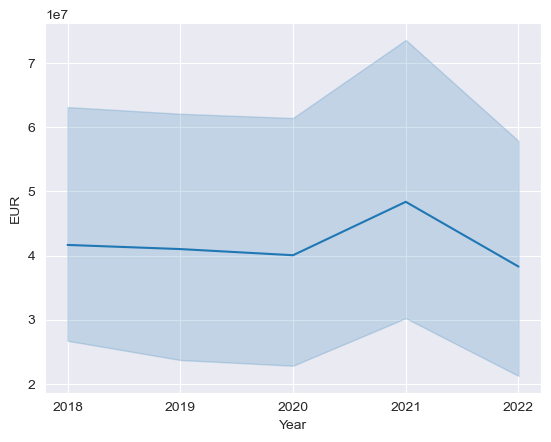

In [72]:
sns.set_style("darkgrid")
sns.lineplot(data=df4, x="Year", y="EUR")

<AxesSubplot:xlabel='Year', ylabel='KG'>

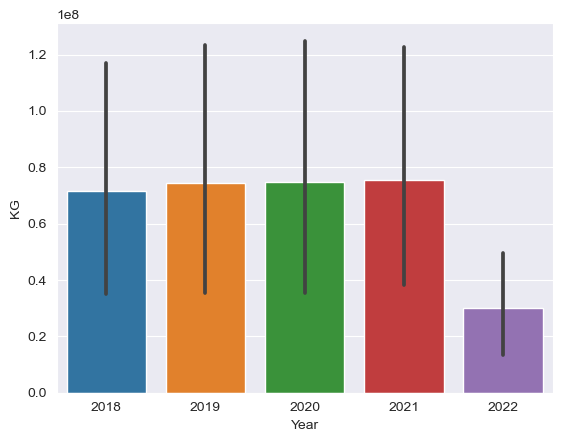

In [73]:
sns.set_style("darkgrid")
sns.barplot(data=df4, x="Year", y="KG")

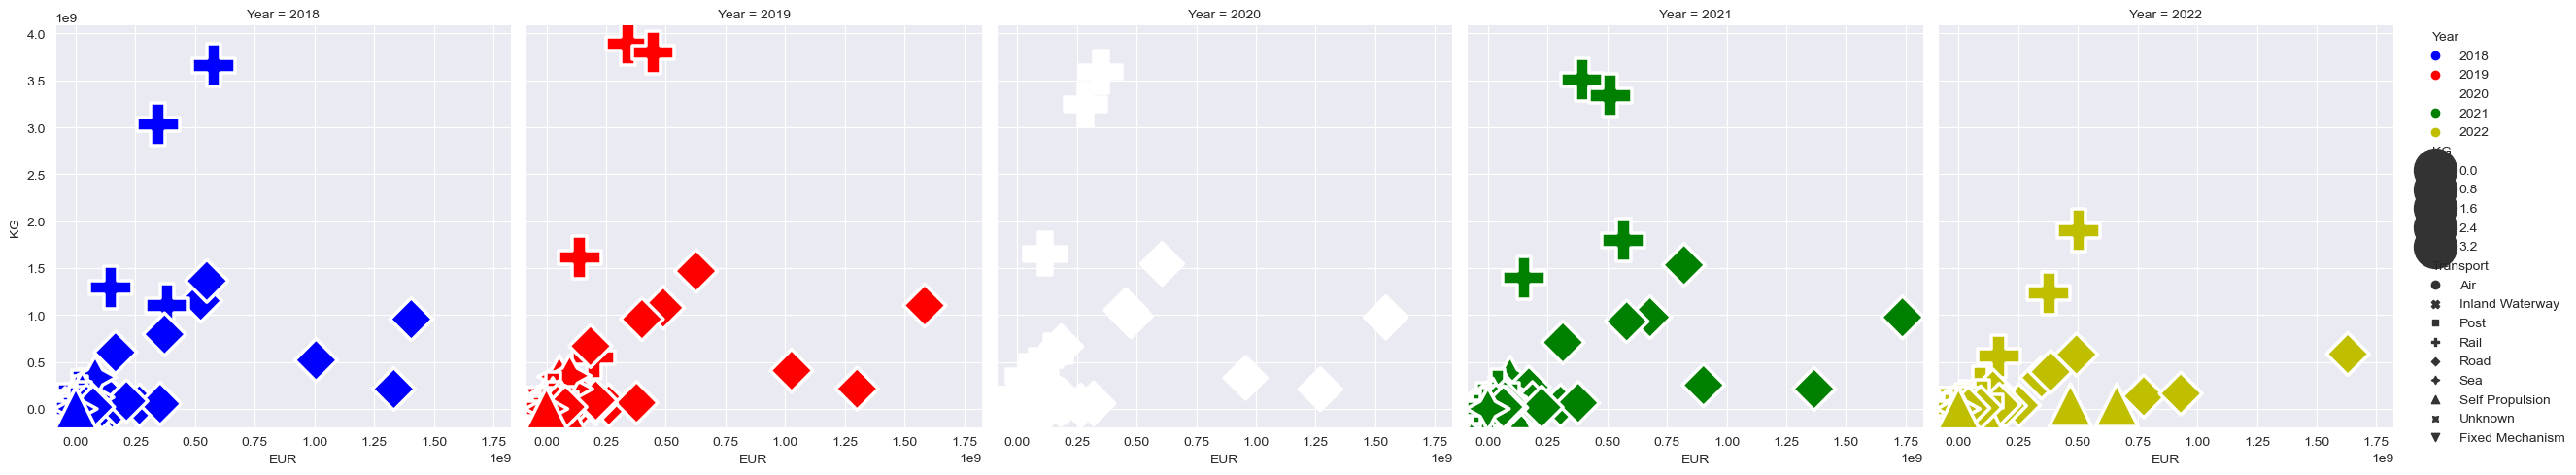

In [81]:
sns.relplot(
    data=df4, x="EUR", y="KG", col="Year",
    hue="Year", size="KG", style="Transport",
    palette=["b", "r", "w", "g", "y"], sizes=(1000, 1000)
)

<AxesSubplot:xlabel='Year', ylabel='Transport'>

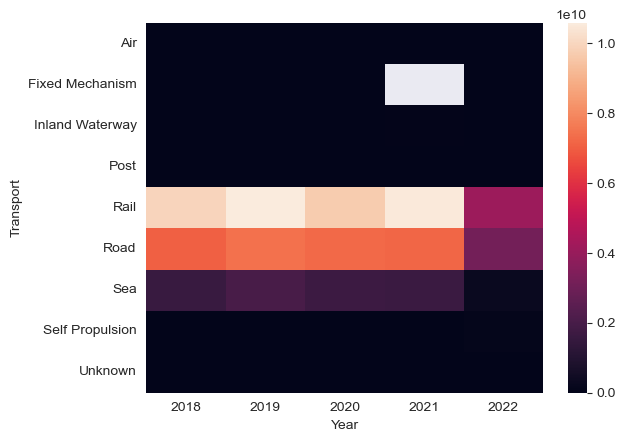

In [86]:
pivot = df4.pivot_table(
    index=["Transport"],
    columns=["Year"],
    values="KG",
    aggfunc=np.sum)
sns.heatmap(pivot)

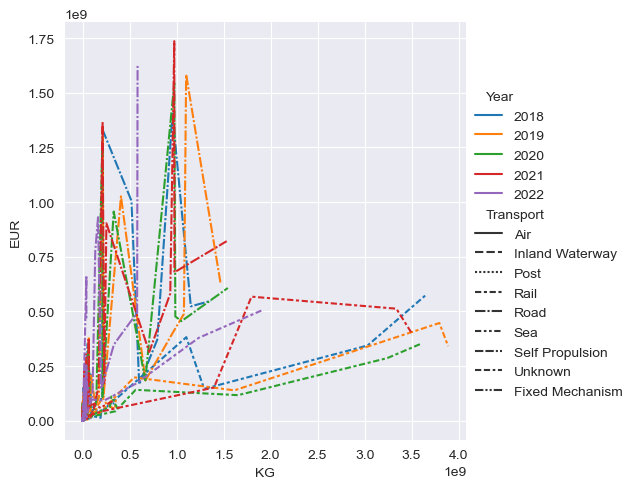

In [93]:
sns.relplot(data=df4,
            kind='line',
            x='KG',
            y='EUR',
            style='Transport',
            hue='Year');

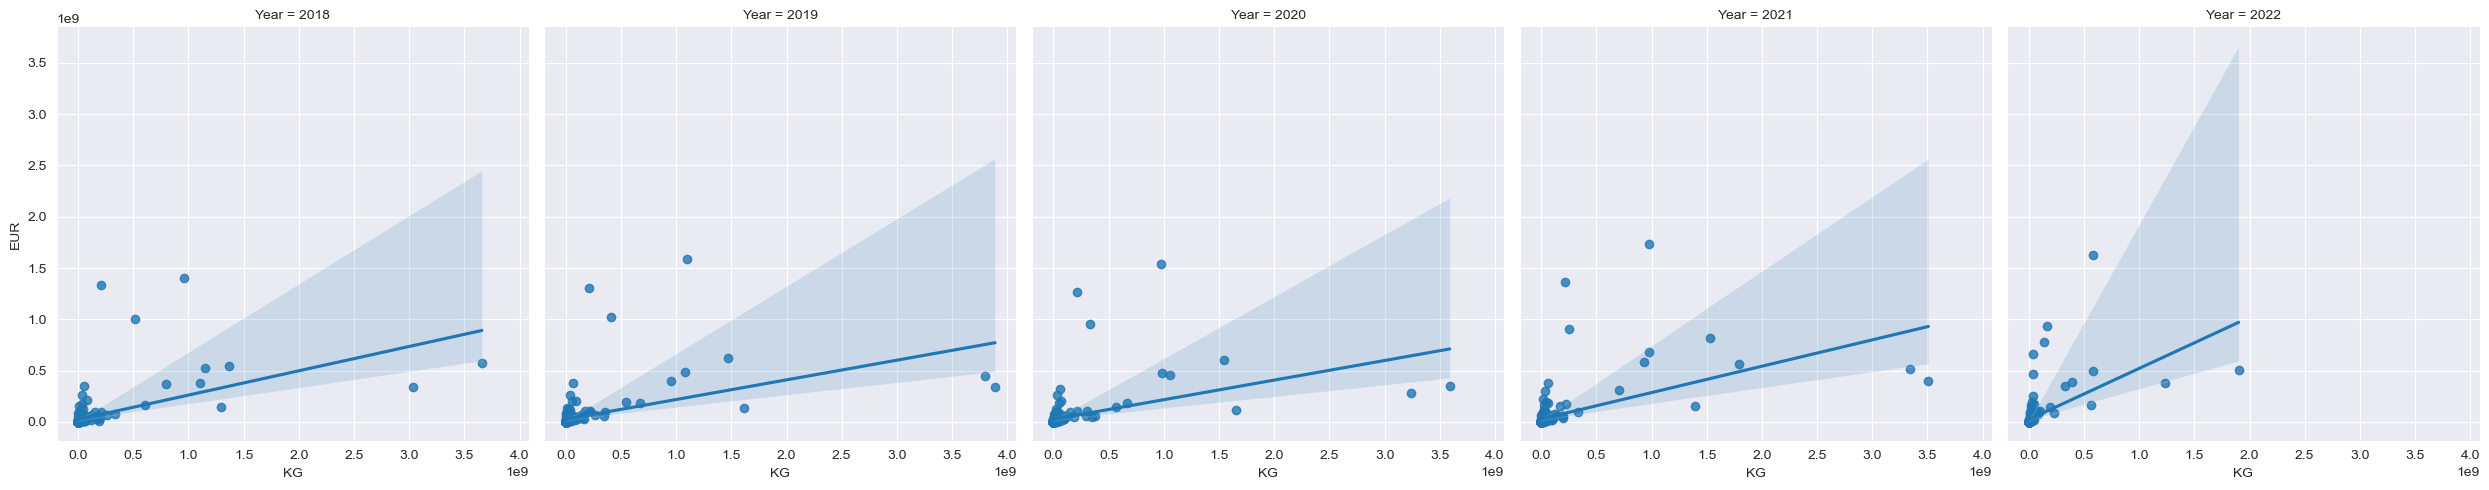

In [97]:
sns.lmplot(data=df4,
            x='KG',
            y='EUR',
            col='Year');

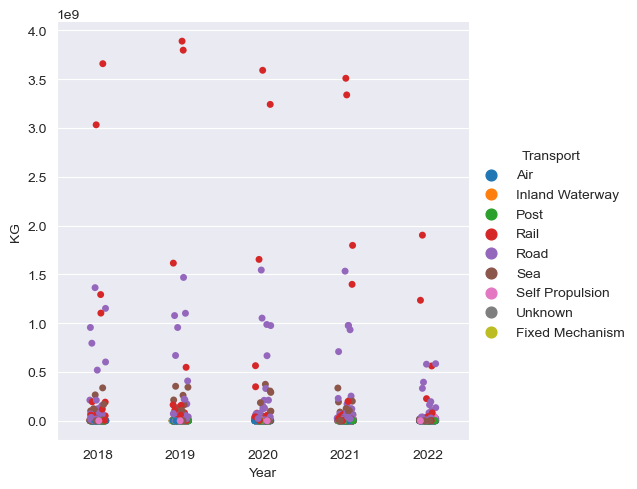

In [137]:
sns.catplot(data=df4,
            x='Year',
            y='KG',
            hue='Transport');

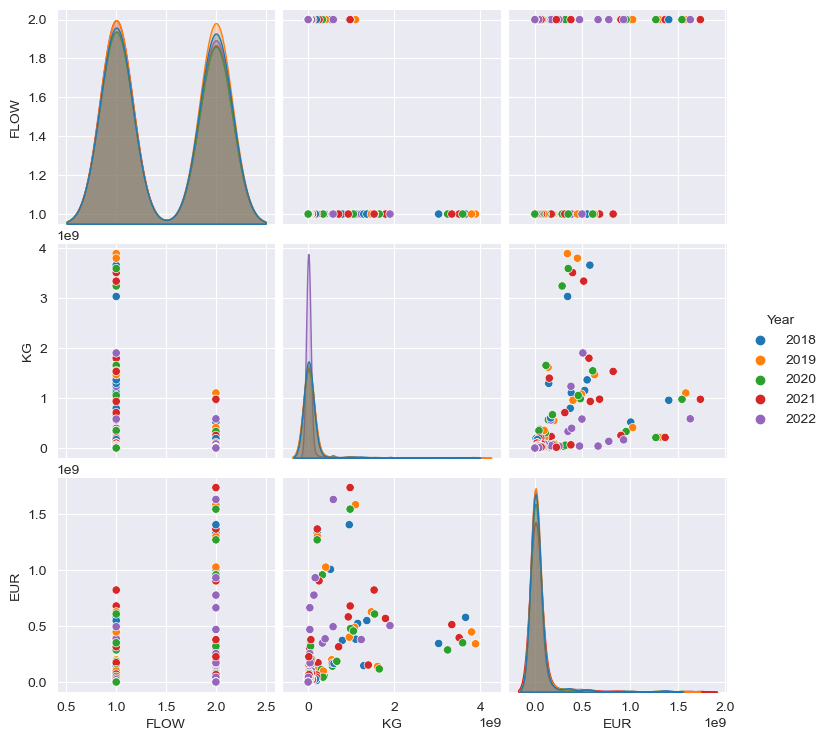

In [142]:
sns.pairplot(df4, hue='Year');

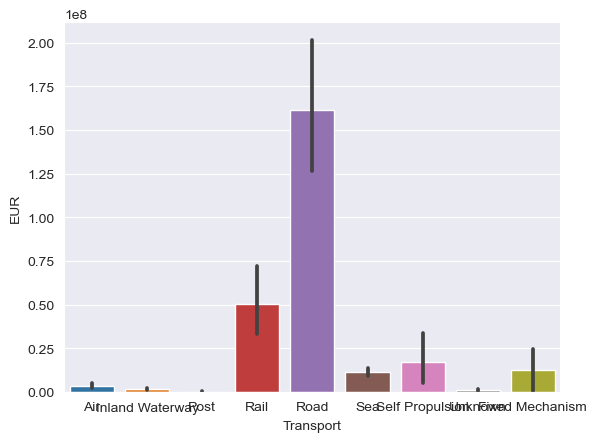

In [143]:
ax = sns.barplot(x="Transport", y="EUR", data=df4)

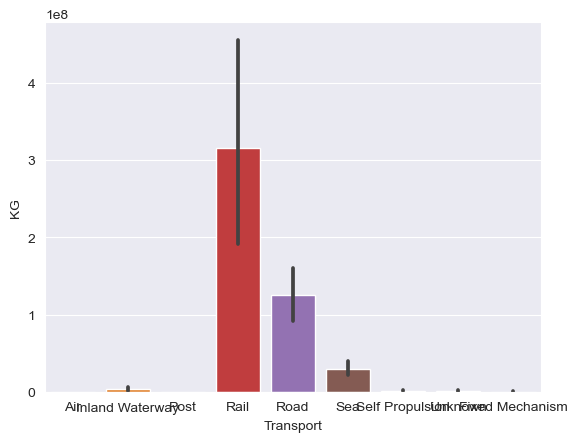

In [144]:
ax = sns.barplot(x="Transport", y="KG", data=df4)

<AxesSubplot:>

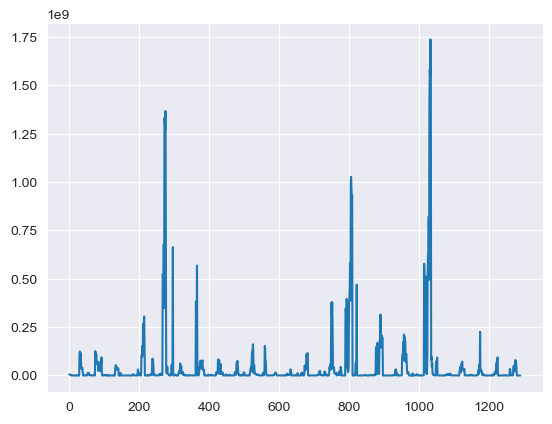

In [149]:
df4.EUR.plot()

<AxesSubplot:>

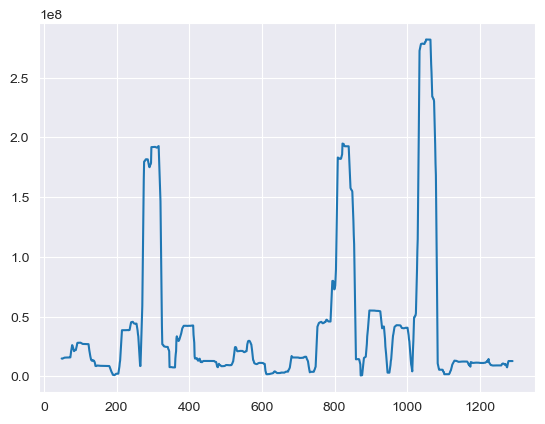

In [151]:
df4.EUR.rolling(window=50).mean().plot()

In [101]:
df5=df4.groupby('Year', as_index=False).agg({'EUR': 'sum'}).rename(columns={'Year': 'ds', 'EUR': 'y'})
df5['ds'] = pd.to_datetime(df5['ds'])
df5

,ds,y
0,2018-01-01,10833777319
1,2019-01-01,11076002387
2,2020-01-01,10016075804
3,2021-01-01,12433439840
4,2022-01-01,9727830520


In [124]:
m = Prophet(interval_width=0.95)
m.fit(df5) # обучили модель
future = m.make_future_dataframe(periods=3, freq='Y')
future.tail()

21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing


,ds
3,2021-01-01
4,2022-01-01
5,2022-12-31
6,2023-12-31
7,2024-12-31


In [125]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3,2021-01-01,1.159330e+10,1.036986e+10,1.284767e+10
4,2022-01-01,1.056847e+10,9.212536e+09,1.182704e+10
5,2022-12-31,8.347608e+09,7.031405e+09,9.575238e+09
6,2023-12-31,8.117157e+09,6.815630e+09,9.411394e+09
7,2024-12-31,8.284203e+09,7.023414e+09,9.547800e+09


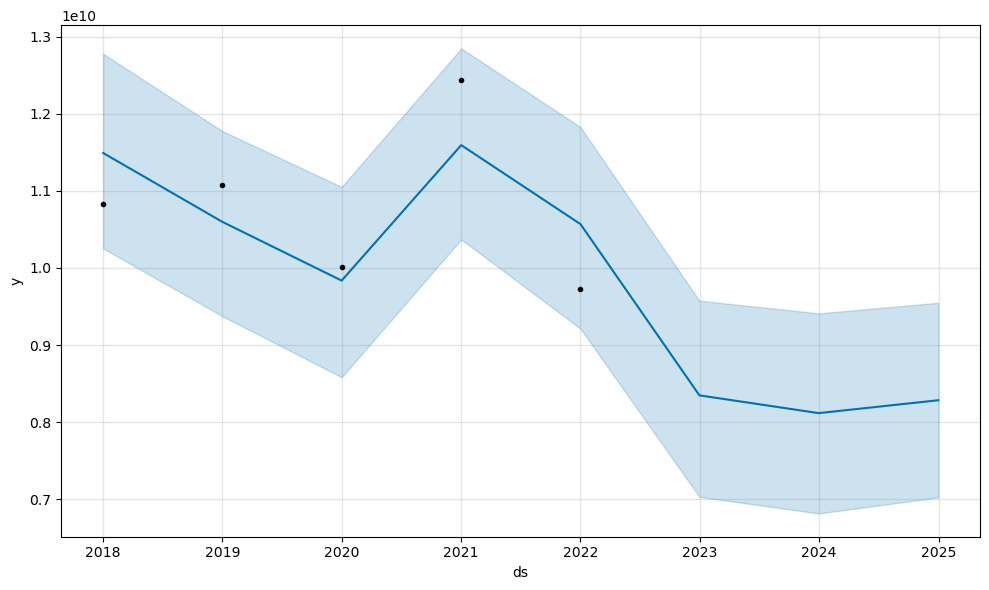

In [141]:
m.plot(forecast);

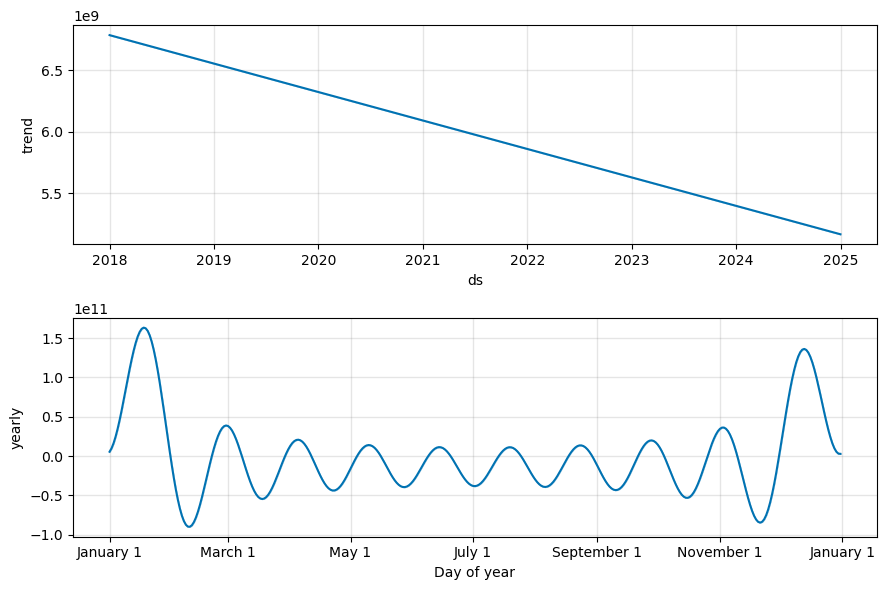

In [142]:
m.plot_components(forecast);

In [143]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df5['ds'], y=df5['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

Вывод: по прогнозу торговля РБ и ЕС будет снижаться в краткосрочной перспективе

<img src= "https://kartinkof.club/uploads/posts/2022-12/1670487425_kartinkof-club-p-kartinki-yeralash-vse-3.png" >